In [1]:
import time
import base64
import datetime
import threading

import cv2
import numpy as np

import ipywidgets as widgets
from IPython.display import display

from util.acl_net import Net
from om_infer import read_class_names, coco80_to_coco91_class, letterbox, draw_bbox

FLAG = True

neth, netw = 640, 640
imgh, imgw = 720, 1280
# https://blog.csdn.net/liuqixuan1994/article/details/88715454
imgbox = widgets.Image(format='jpg', height=imgh, width=imgw)
display(imgbox)

def main():
    ground_truth_json = '/home/HwHiAiUser/sample/dataset/annotations/instances_val2017.json'
    coco_names = read_class_names(ground_truth_json)
    coco91class = coco80_to_coco91_class()
    device_id = 0
    model_path = '/home/HwHiAiUser/sample/yolov5/output/yolov5s_v6.1_sim_nms_bs1.om'
    model = Net(device_id=device_id, model_path=model_path)

    cap = cv2.VideoCapture('world_cup.mp4')
    fps = int(cap.get(5))
    videoWriter = None
    
    while True:
        # Read a picture from the camera
        ret, img_bgr = cap.read()  # YUV420SP NV12 8bit
        if not ret:
            break
        
        imgh, imgw = img_bgr.shape[0], img_bgr.shape[1]
        imginfo = np.array([neth, netw, imgh, imgw], dtype=np.float16)
        img_padding = letterbox(img_bgr, new_shape=(neth, netw))[0]  # padding resize bgr
        
        img0 = []
        img = []
        img_info = []
        
        img0.append(img_bgr)
        img.append(img_padding)
        img_info.append(imginfo)
        img = np.stack(img, axis=0)
        img_info = np.stack(img_info, axis=0)
        img = img[..., ::-1].transpose(0, 3, 1, 2)  # BGR tp RGB
        image_np = np.array(img, dtype=np.float32)
        image_np_expanded = image_np / 255.0
        img = np.ascontiguousarray(image_np_expanded).astype(np.float16)
        
        result, dt = model([img, imginfo])  # net out, infer time
        batch_boxout, boxnum = result

        img0_list = img0
        valid_num = 1 # 如果模型是可以批输入的，valid_num代表这批图像当中有效的图像张数，比如batchsize=4，可能出现只有3张的图，凑不够一批的情况
        for idx in range(valid_num):
            num_det = int(boxnum[idx][0])
            boxout = batch_boxout[idx][:num_det * 6].reshape(6, -1).transpose().astype(np.float32)  # 6xN -> Nx6
            img_dw = draw_bbox(boxout, img0_list[idx], (0, 255, 0), 2, coco_names)
            imgbox.value = cv2.imencode('.jpg', img_dw)[1].tobytes()
        
        if videoWriter is None:
            fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')  # opencv3.0
            videoWriter = cv2.VideoWriter('video-result.mp4', fourcc, fps, (img_dw.shape[1], img_dw.shape[0]))
        videoWriter.write(img_dw)

            
if __name__ == '__main__':
    main()

Image(value=b'', format='jpg', height='720', width='1280')

KeyboardInterrupt: 

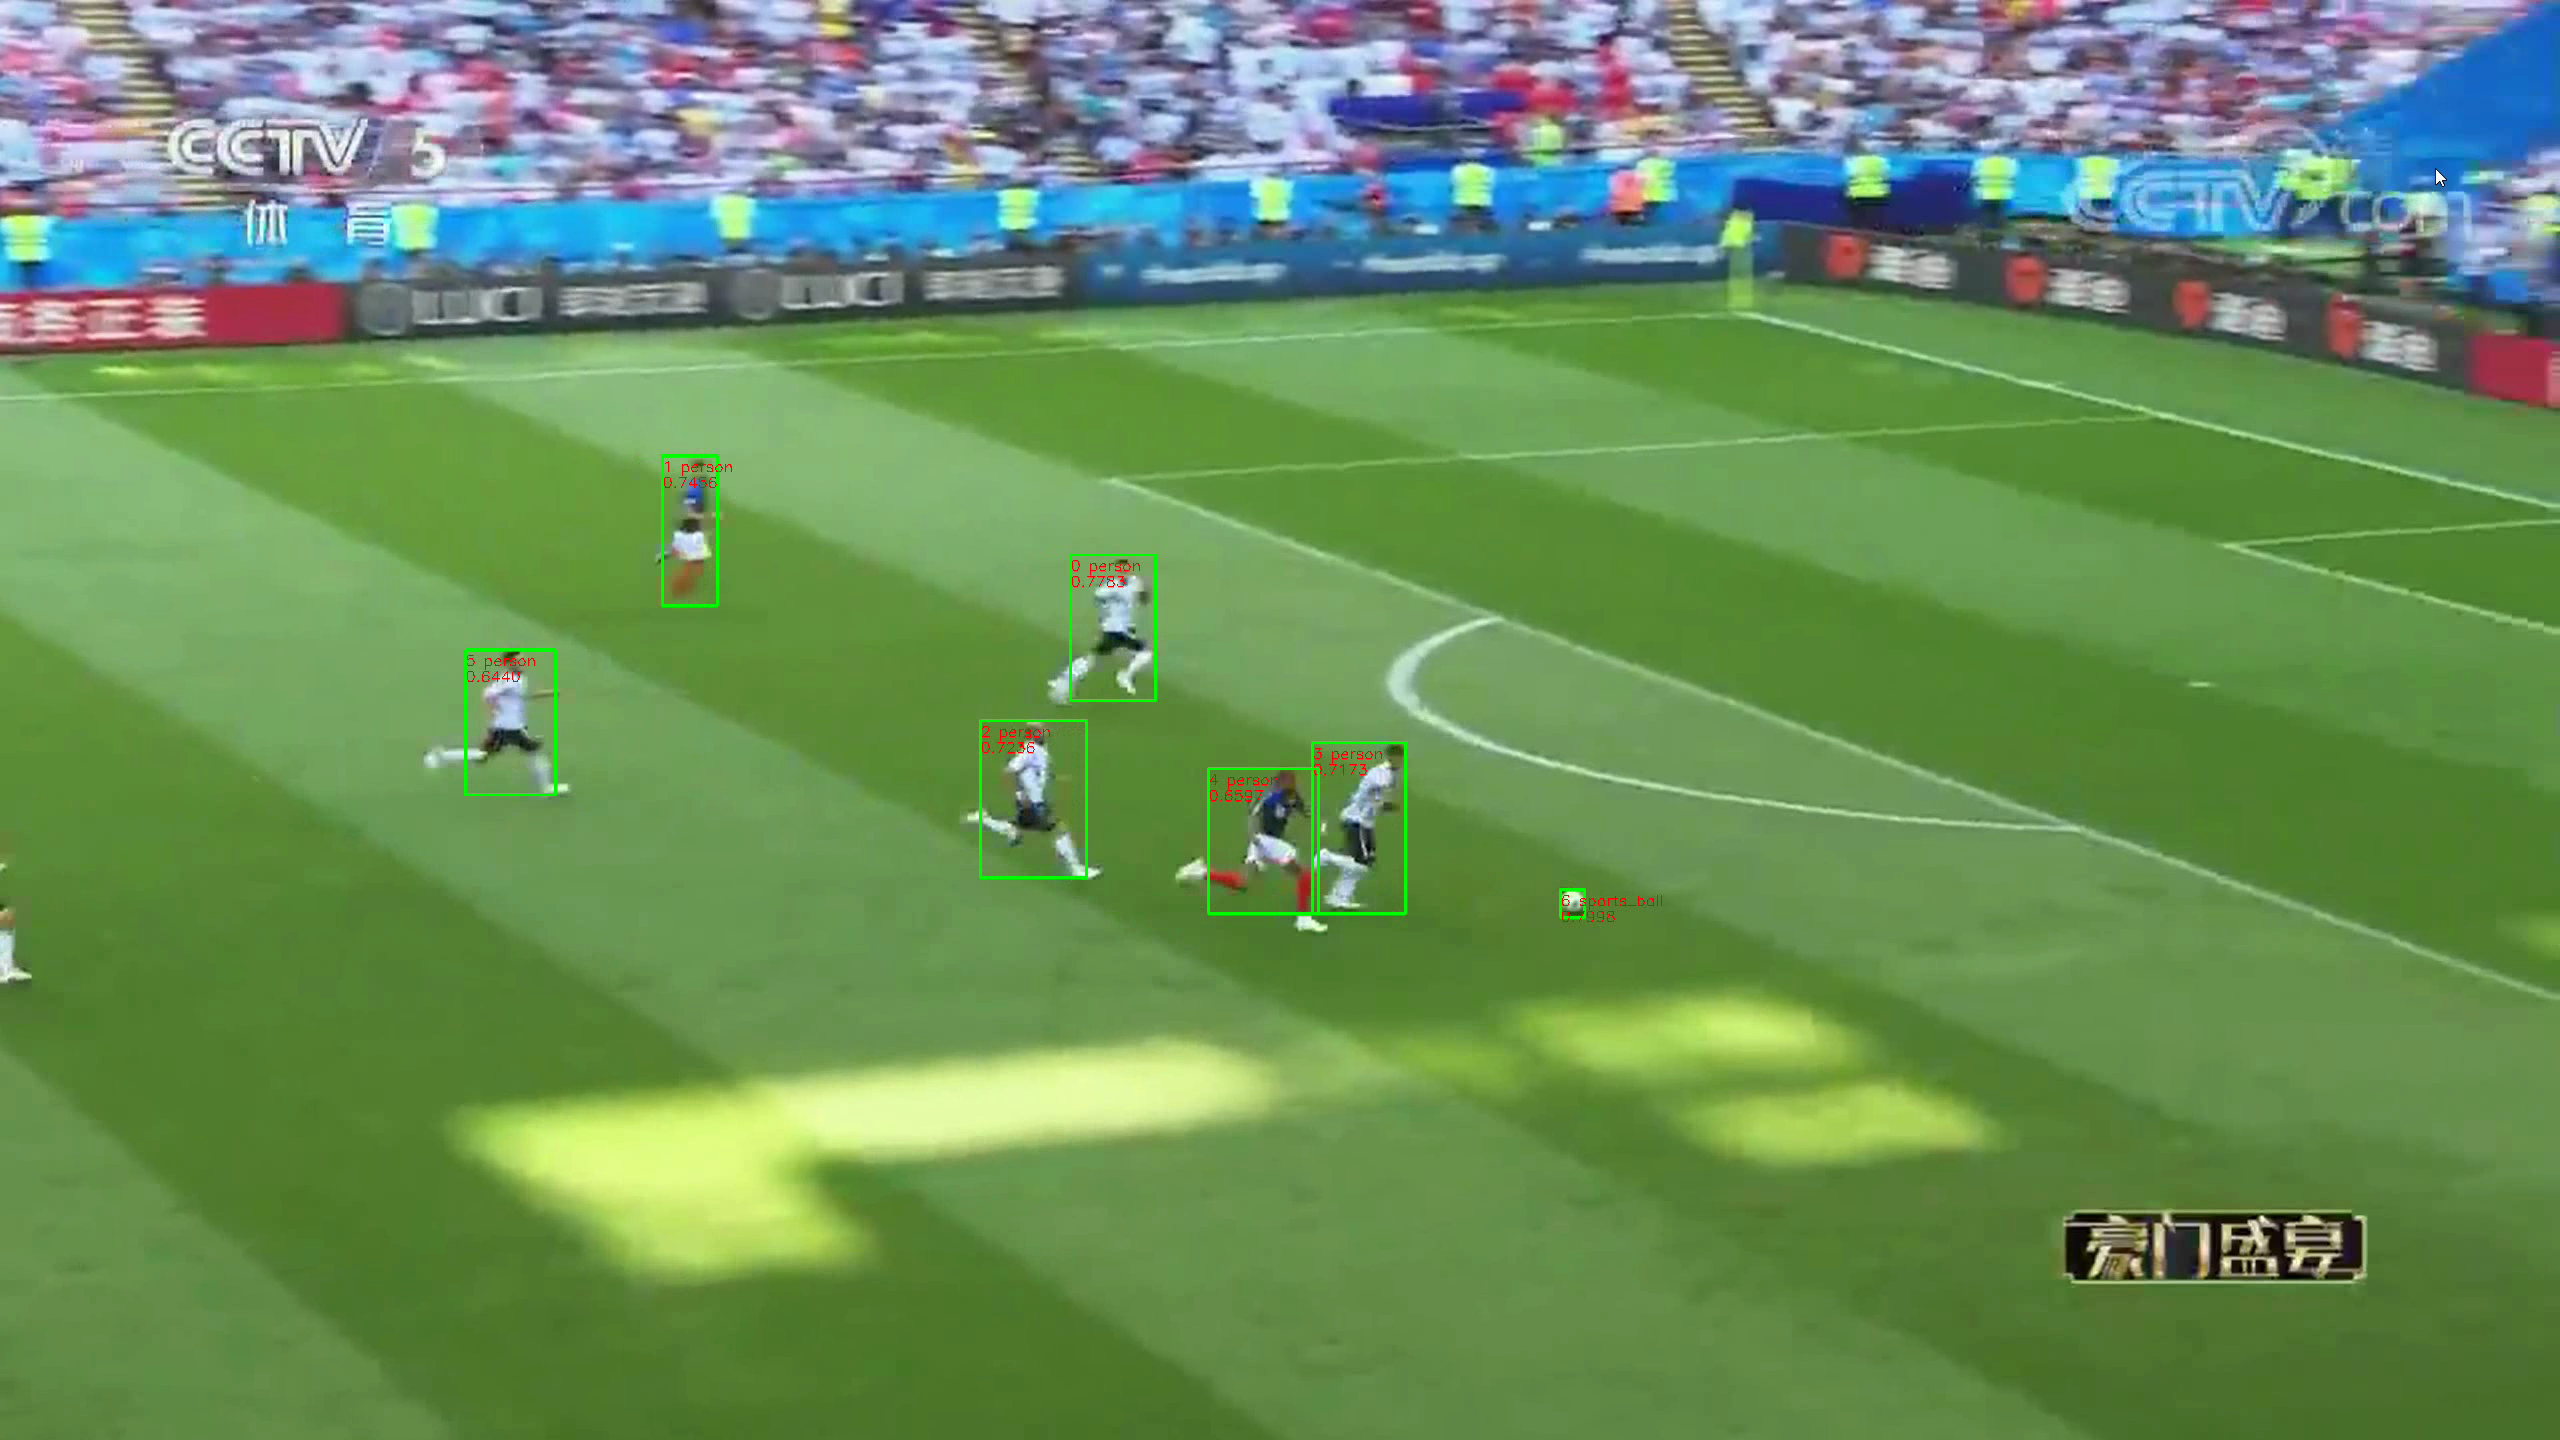

In [4]:
import os
import cv2
import time
from PIL import Image
from IPython.display import clear_output,  display

video_path = './video-result.mp4'
if not os.path.exists(video_path):
        print("视频文件不存在")
video = cv2.VideoCapture(video_path)

while(True):
    try:
        clear_output(wait=True)
        ret, frame = video.read()
        if not ret:
            break
        lines, columns, _ = frame.shape
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(frame)
        display(img)
        # 控制帧率
        # time.sleep(0.02)  
    except KeyboardInterrupt:
        video.release()
